# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. Apply a distortion correction to raw images.

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import glob
import matplotlib.image as mpimg

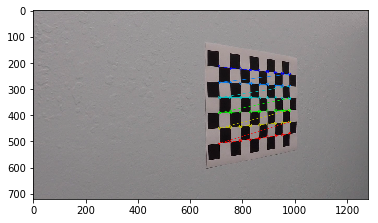

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in tqdm(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)


In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

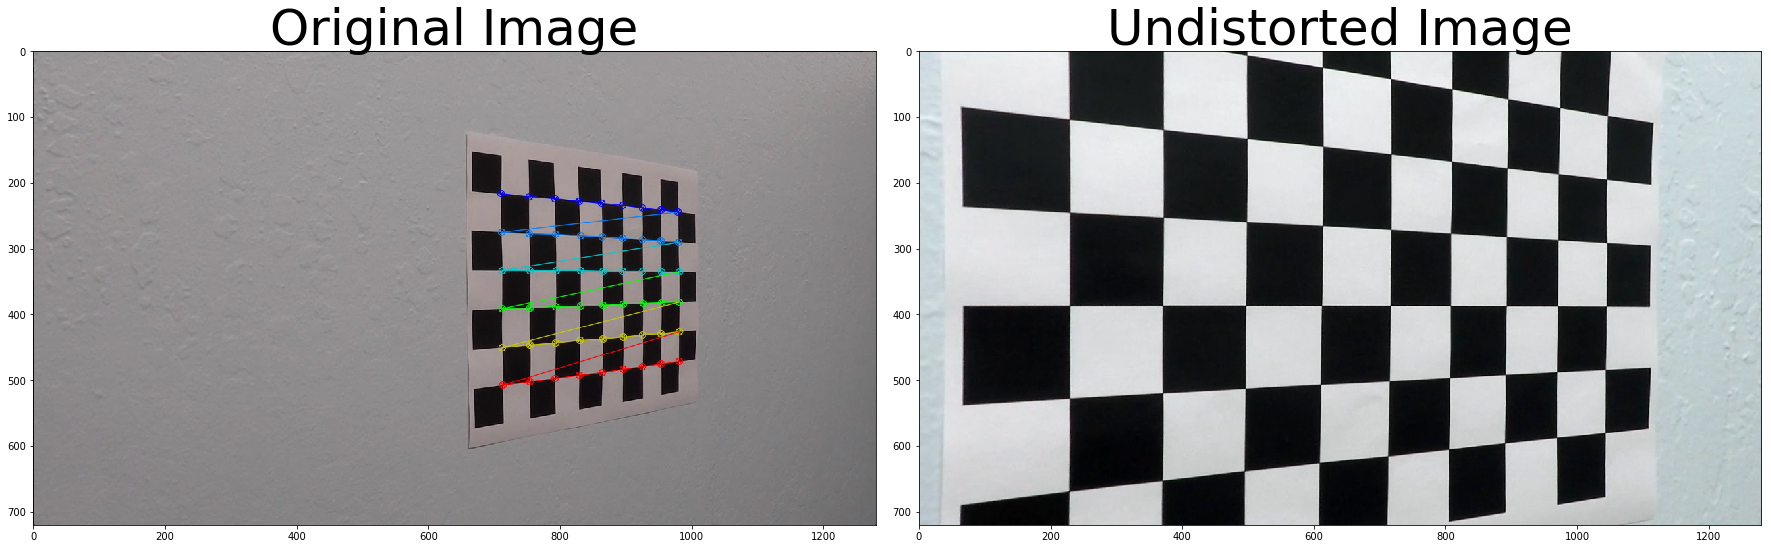

In [4]:
test_img = cv2.imread(images[0])

undistorted = cal_undistort(test_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('images.png')

# Use color transforms, gradients, etc., to create a thresholded binary image.

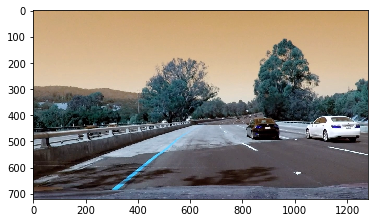

In [5]:
img_line = os.listdir(os.path.join('.', 'test_images'))
lines = [cv2.imread(os.path.join('.', 'test_images', x)) for x in img_line]
test_line = lines[2]
plt.imshow(test_line)
plt.savefig('lane_line.png')

In [6]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def color_transform(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, 11)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 200
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 195
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

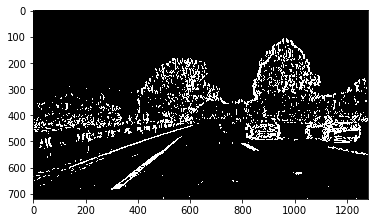

In [7]:
color_transformation = color_transform(test_line)
plt.imshow(color_transformation, cmap='bone')
plt.savefig('color_transformation.png')

# Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
def warp(img):
#     src = np.float32([
#     [530, 500],
#     [0, img.shape[0]],
#     [img.shape[1], img.shape[0]],
#     [780, 500]
#     ])
    
#     dst = np.float32([
#         [0, 0],
#         [0, img.shape[0]],
#         [img.shape[1], img.shape[0]],
#         [1080, 0]
#     ])
    src = np.float32([
    [500, 500],
    [300, img.shape[0]*0.9],
    [1100, img.shape[0]*0.9],
    [830, 500]
    ])
    
    dst = np.float32([
        [100, 50],
        [100, img.shape[0]*0.9],
        [img.shape[1]-100, img.shape[0]*0.9],
        [1080, 50]
    ])
    plt.scatter(src[:,0], src[:, 1])
    plt.scatter(dst[:,0], dst[:, 1])
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    
    x = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return x

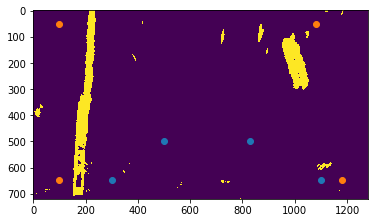

In [9]:
warped = warp(color_transformation)
plt.imshow(warped)
plt.savefig('warped.png')

# Detect lane pixels and fit to find the lane boundary.

In [10]:
prev_left = [1, 1, 1]
prev_right = [1, 1, 1]

In [11]:
def poly_function(inputs, fit):
    return fit[0] * (np.array(inputs) ** 2) + fit[1] * np.array(inputs) + fit[2]
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    global prev_right, prev_left
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fit = prev_left
        right_fit = prev_right
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.plot(left_fitx, ploty)
    plt.plot(right_fitx, ploty)
    return out_img, left_fit, right_fit, ploty

def first_step(binary_warped):
    global prev_right, prev_left
    
    out_img, left, right, ploty = fit_polynomial(binary_warped)
    prev_left = left
    prev_right = right
    
    return out_img, left, right, ploty

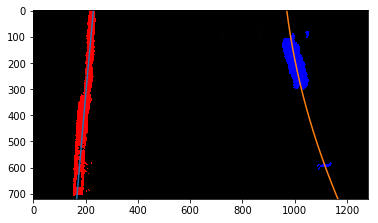

In [12]:
out_img, left_fit, right_fit, ploty = first_step(warped)
plt.imshow(out_img)

# Determine the curvature of the lane and vehicle position with respect to center.

In [13]:
def deviation_from_center(image, plotly, left_fit, right_fit):  
    xm_per_pix = 3.7/700
    
    center_of_image = image.shape[1]//2
    y_eval = np.max(plotly)
    left_pt = poly_function(y_eval, left_fit)
    right_pt = poly_function(y_eval, right_fit)
    return (((right_pt + left_pt)//2) - center_of_image) * xm_per_pix

center = deviation_from_center(out_img, ploty, left_fit, right_fit)

print(center)

0.13214285714285715


In [14]:
def generate_data(left_curve, right_curve, ploty, ym_per_pix, xm_per_pix):
    plotly = np.array(ploty)
    rightx = poly_function(plotly, right_curve)
    leftx = poly_function(plotly, left_curve)
    
    left_fit_cr = np.polyfit(plotly*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(plotly*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real(left, right, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 37/7000 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(left, right, ploty, ym_per_pix, xm_per_pix)
    
    y_eval = np.max(ploty)
    # Calculation of R_curve (radius of curvature)
    left_curverad = ym_per_pix * ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ym_per_pix * ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty)

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

858.6605467436425 m 82.55415379271415 m


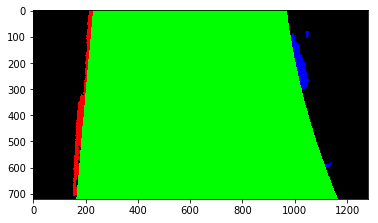

In [15]:
def draw_lane_area(image, ploty, right_fit, left_fit):
    # Create point set and then pass it into fillContours or something
    right_x = poly_function(ploty, right_fit)
    left_x = poly_function(ploty, left_fit)
    # Create point set
    right_points = np.array([[xi, yi] for xi, yi in zip(right_x, ploty)]).astype(np.int32)
    left_points = np.array([[xi, yi] for xi, yi in zip(left_x, ploty)]).astype(np.int32)

    points = np.concatenate([left_points, np.flip(right_points, 0)])
    return cv2.fillPoly(image, [points], color=[0,255,0])
plt.imshow(draw_lane_area(out_img, ploty, right_fit, left_fit))

# Warp the detected lane boundaries back onto the original image.

In [16]:
def unwarp(img):
    src = np.float32([
    [500, 500],
    [300, img.shape[0]*0.9],
    [1100, img.shape[0]*0.9],
    [830, 500]
    ])
    
    dst = np.float32([
        [100, 50],
        [100, img.shape[0]*0.9],
        [img.shape[1]-100, img.shape[0]*0.9],
        [1080, 50]
    ])
    plt.scatter(src[:,0], src[:, 1])
    plt.scatter(dst[:,0], dst[:, 1])
    
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

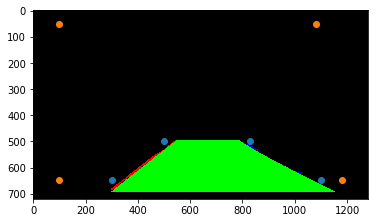

In [17]:
unwarped = unwarp(out_img)
plt.imshow(unwarped)
plt.savefig('unwarped.png')

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [18]:
def process_image(image):
    undistorted = cal_undistort(image, objpoints, imgpoints)
    color_transformation = color_transform(undistorted)
    warped = warp(color_transformation)
    out_imga, aleft, aright, aploty = first_step(warped)
    
    left_rad, right_rad = measure_curvature_real(aleft, aright, aploty)
    center = deviation_from_center(out_imga, aploty, aleft, aright)
    result = draw_lane_area(out_imga, aploty, aright, aleft)
    
    a = unwarp(result) 
    weighted = cv2.addWeighted(image, 0.8, a, 0.5, 0)
    cv2.putText(weighted, "LEFT CURVATURE: " + str('%.2f' % left_rad), (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 5)
    cv2.putText(weighted, "RIGHT CURVATURE: " + str('%.2f' % right_rad), (10,150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 5)
    cv2.putText(weighted, "DEVIATION FROM CENTER: " + str('%.2f' % center), (10,225), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 5)
    return weighted

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output.mp4.
Moviepy - Writing video ./output.mp4



Moviepy - Done !
Moviepy - video ready ./output.mp4
CPU times: user 20min 42s, sys: 52.2 s, total: 21min 34s
Wall time: 19min 20s


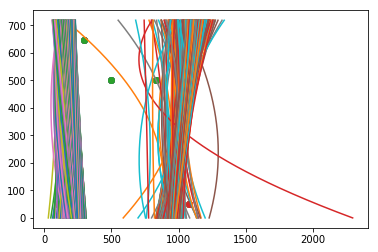

In [20]:
white_output = './output.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))